In [1]:
# Takes a while to load all when you started 
from __future__ import print_function, unicode_literals, absolute_import, division
# Here import important system functions 
import os
import sys
# import tk for getting the directory faster. dont need this in a command line/server version
from tkinter import *
from tkinter import filedialog
# you need numpy as always
import numpy as np
import csv
# Need tqdm to resolve looping time search for what tqdm is upto, but tqdm is basically a package help with looping time
from tqdm import tqdm
# if you dont need to plot in jupyter you don need these. Some magic interperters need to be removed for command line version. 
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Glob and tifffile are needed
from glob import glob
from tifffile import imread,imwrite
# csb deep is to take normalization 
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
# This is your stardist models and everything in stardist coming from. 
from stardist import fill_label_holes,random_label_cmap, _draw_polygons, export_imagej_rois,relabel_image_stardist, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
# Set random seed for you color map. You do not really need this to be 6 all the time, but its okay. 
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [2]:
# Lets start some trainings! GT labels created by labkit and you can learn it easily by any online tutorials. 
#this is for getting the directory, and helps saving time of typing what ever directory it is. 
root = Tk()
pathname = filedialog.askdirectory()
# Close Tk window
root.destroy()
# Change directory
os.chdir(pathname)

In [3]:
os.getcwd()

'/Users/eliasguan/Desktop/EG_Nucleus_Segementation_test/022523_smFISH_analysis_v2.0_development/Weekly_Reports/2024Spring/040824'

In [4]:
X = sorted(glob('Training_GT/*.tif'))
Y = sorted(glob('Original Image/*.tif'))

In [5]:
X
# Make sure your order of X and Y are the same. 

['Training_GT/GT for Image 0.tif',
 'Training_GT/GT for Image 1.tif',
 'Training_GT/GT for Image 2.tif',
 'Training_GT/GT for Image 3.tif',
 'Training_GT/GT for Image 4.tif',
 'Training_GT/GT for Image 5.tif',
 'Training_GT/GT for Image 6.tif',
 'Training_GT/GT for Image 7.tif',
 'Training_GT/GT for Image 8.tif',
 'Training_GT/GT for Image 9.tif']

In [6]:
Y

['Original Image/sample_image_000.tif',
 'Original Image/sample_image_001.tif',
 'Original Image/sample_image_002.tif',
 'Original Image/sample_image_003.tif',
 'Original Image/sample_image_004.tif',
 'Original Image/sample_image_005.tif',
 'Original Image/sample_image_006.tif',
 'Original Image/sample_image_007.tif',
 'Original Image/sample_image_008.tif',
 'Original Image/sample_image_009.tif']

In [7]:
GT = list(map(imread,X))
Original = list(map(imread,Y))

In [8]:
# Load a example image
i = min(4, len(X)-1)
img, lbl = Original[i], fill_label_holes(GT[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

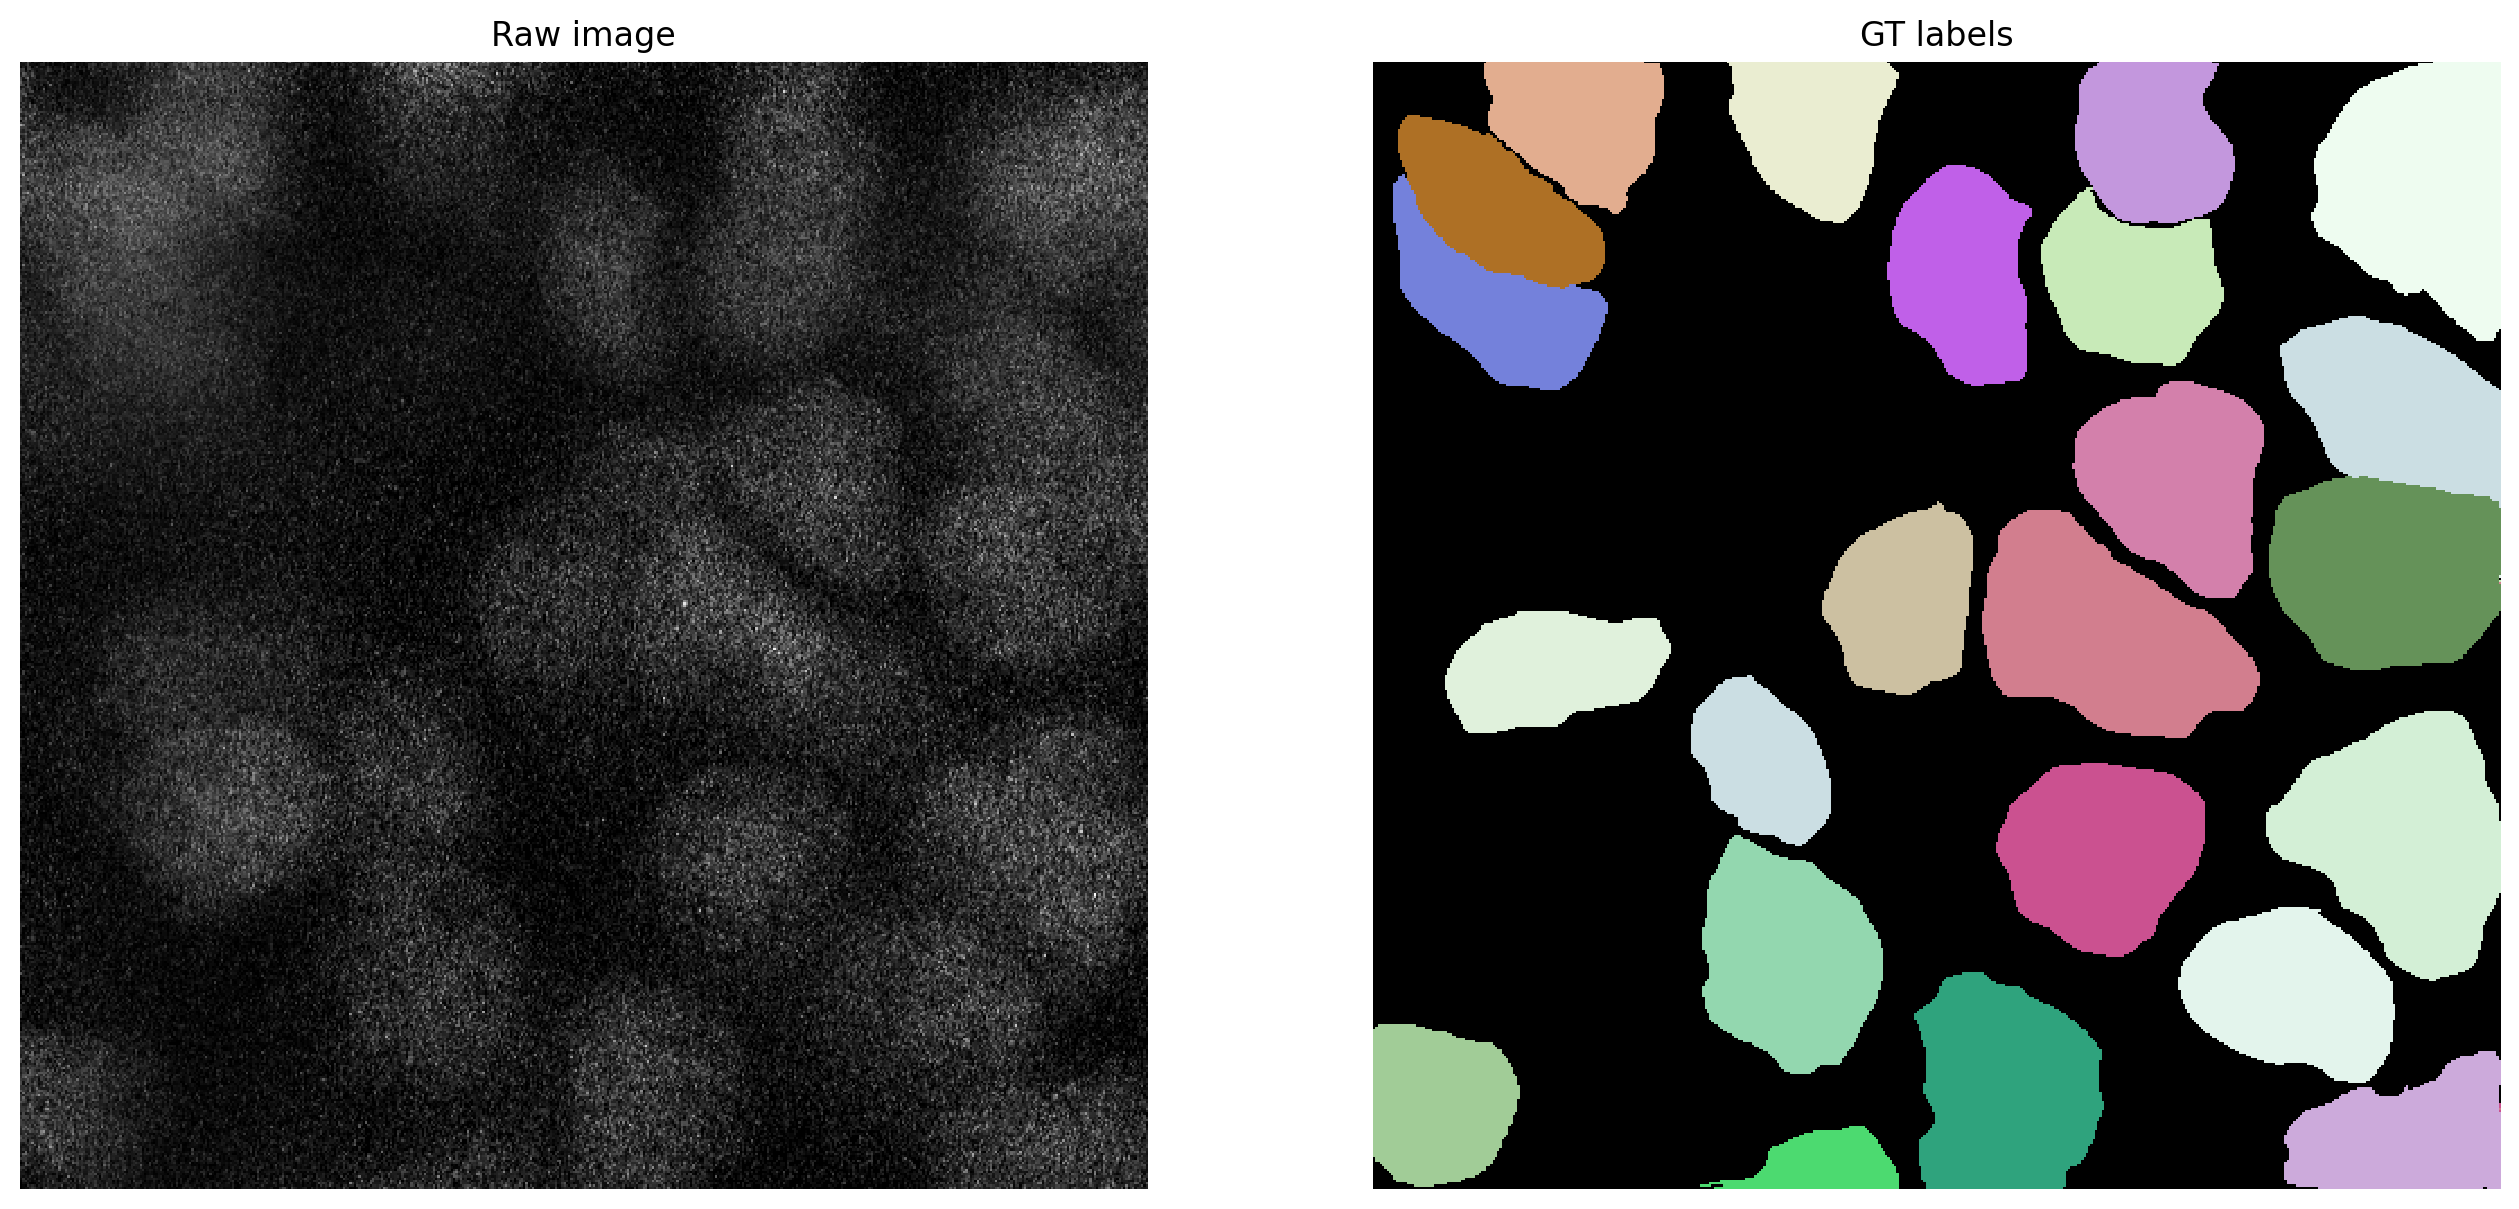

In [9]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [10]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    GT_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in GT]
    mean_iou = matching_dataset(GT, GT_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]


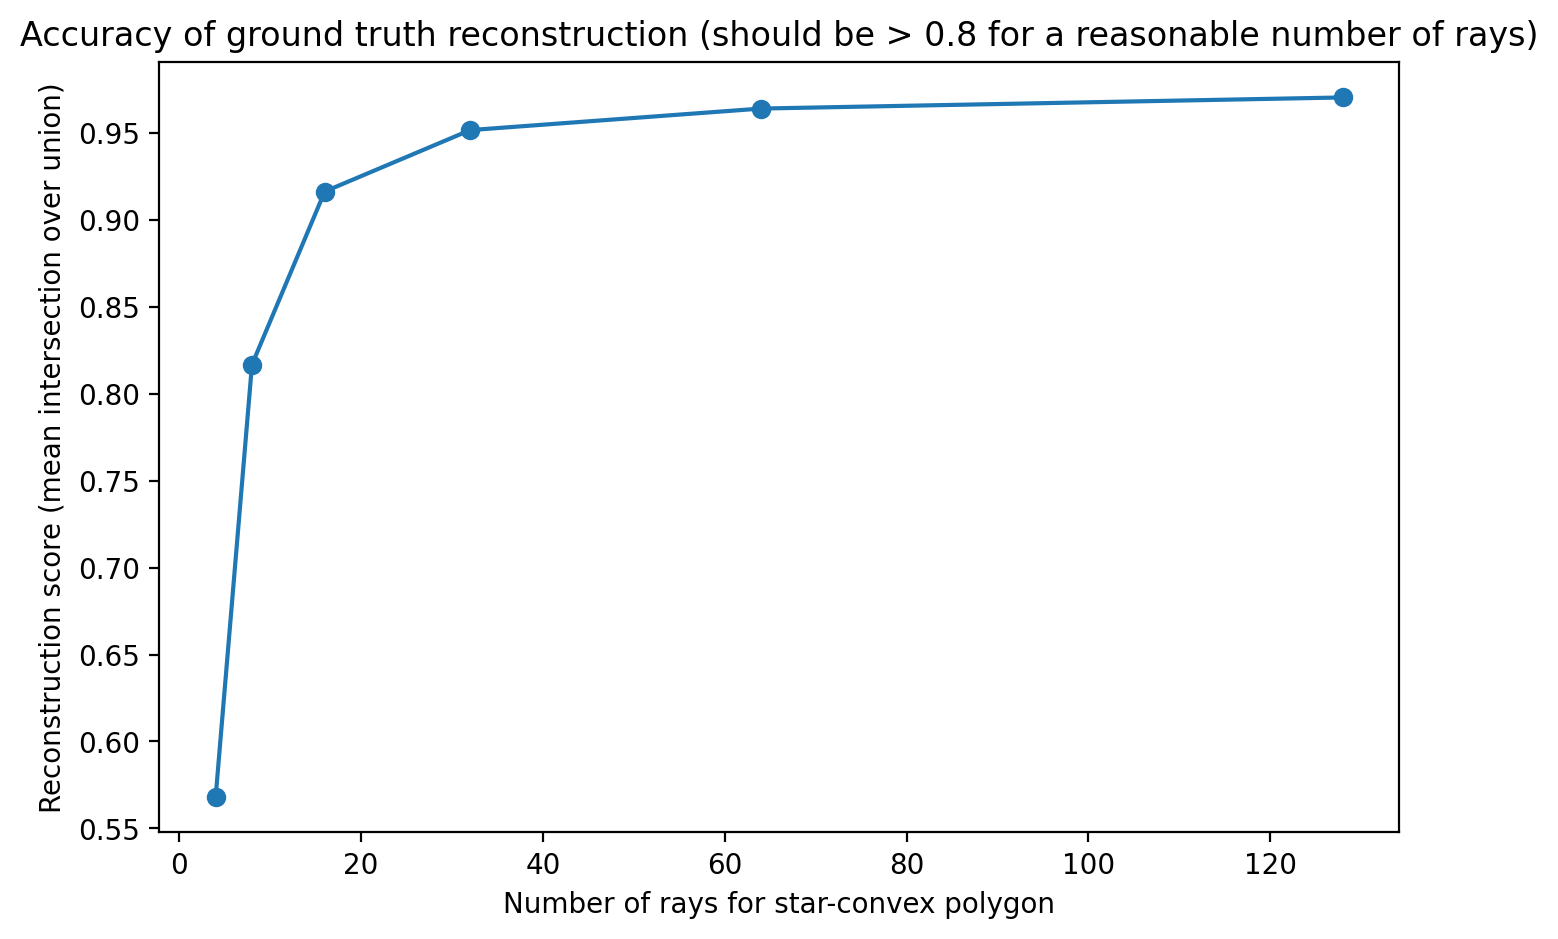

In [11]:
# An estimation of how good your data is. Should be over 0.8 to be a good estimation, our data is far over 0.8
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

In [12]:
n_channel = 1 if Original[0].ndim == 2 else Original[0].shape[-1]
n_channel

1

In [13]:
# Nomralize image and fill holes in GT
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

Normalized_original = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(Original)]
Filled_GT = [fill_label_holes(y) for y in tqdm(GT)]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 179.69it/s]


In [14]:
assert len(Normalized_original) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(Normalized_original))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [Normalized_original[i] for i in ind_val]  , [Filled_GT[i] for i in ind_val]
X_trn, Y_trn = [Normalized_original[i] for i in ind_train], [Filled_GT[i] for i in ind_train] 
print('number of images: %3d' % len(Normalized_original))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  10
- training:         8
- validation:       2


In [15]:
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [16]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [17]:
model = StarDist2D(conf, name='stardist', basedir='models')

base_model.py (149): output path for model already exists, files may be overwritten: /Users/eliasguan/Desktop/EG_Nucleus_Segementation_test/022523_smFISH_analysis_v2.0_development/Weekly_Reports/2024Spring/040824/models/stardist
2024-04-01 18:33:39.980137: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-04-01 18:33:39.980218: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-01 18:33:39.980231: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-01 18:33:39.980294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-01 18:33:39.980333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (d

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [18]:
# Make sure your FOV is not smaller than your object size
median_size = calculate_extents(list(Filled_GT), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2024-04-01 18:33:40.992189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


median object size:      [85.5 82.5]
network field of view :  [92 90]


In [20]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [27]:
%load_ext tensorboard
quick_demo = True
if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val),augmenter=augmenter)
None;

NOTE: This is only for a quick demonstration!
      Please set the variable 'quick_demo = False' for proper (long) training.


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=models/stardist/weights_best.h5